<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/clustering_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Clustering: Representation, Evaluation, and Optimization via Gradient Descent**

(Fayyaz Minhas)

Clustering is an essential machine learning technique used to **partition data into meaningful groups**. In this tutorial, we will breakdown clustering into the **representation, evaluation, and optimization** (REO) framework.

Note that the goal of this tutorial is to help you understand how we can use this framework to solve any machine learning problem and give you a conceptual understanding of clustering. For practical applications of clustering, much more effieicnet methods and libraries are available.

Below, we breakdown clustering into REO:

## **1. Representation: Assigning Data to Clusters**
Assume we have set of points in a dataset $X \in \mathbb{R}^{N \times d} $ composed of **N** points (in rows) in **d-dimensional features** (in columns). We want to find a smaller set of  $K$ "exemplar" points which can "reliably" represent the entire dataset $X$.
Mathematically, this set of exemplars can be represented by a matrix $C \in \mathbb{R}^{K \times d} $ where each exemplar point is a row.

Once we know $C$, we can assign a point $x$ the exemplar which is closest to it from all $K$ exemplars. Points that are closer to a certain exemplar than other exemplars would form a cluster and reveal the underlying structure of the data. Thus, we have can haa cluster center assignment function given by:

$$
a(x;C) = argmin_{j \in \{1...K\}} \| x - C_j \|^2
$$


Note that the above function is parameterized by the clustering points $C$ which need to be found from the training data.


---

## **2. Evaluation: Measuring Clustering Distortion**
As discussed above, in exemplar based cluster, we represent a point $x$ from a given dataset using an exemplar from a given set $C$ of $K$ exemplars. Given a training, set we can quantitatively evaluate the quality of a given set of exemplar points $C$ by simply measuring how much "distortion" results from using the $K$ points in $C$. Distortion measures the total squared distance of a given point in the training  each point to its assigned exemplar $a(x;C)$:

$$
d(x;C) = \| x - C_j \|^2
$$

where $ j = a(x;C)$. Or we can alternatively, write it as:

$$
d(x;C) = min_{j \in \{1, \dots, K\}}\| x - C_j \|^2
$$

The overall distorion over the given set of $N$ training points in $X$ can be written as:
$$
D(X;C) = \sum_{j \in \{1, \dots, N\}} d(x_i;C)
$$

This distortion function acts as our **objective function**, where:
- **Lower distortion** means data points are well represented by their exemplars and thus "good" clustering.
- **Higher distortion** indicates poor clustering (points are far from their assigned exemplars in $C$).

Thus, the goal of clustering is to **minimize this distortion** with respect to the matrix $C$, i.e., we want to find optimal exemplars $C^*$ such that:

$$
C^* = argmin_C D(X;C)
$$

Below we will use gradient descent in PyTorch to solve this.

---

## **3. Optimization: Gradient-Based Learning of Cluster Centers**

### **Gradient Computation**
The optimization problem involves minimizing the distortion function \( D(C) \), which can be done through gradient descent. One can manually calculate the derivative $\frac{\partial D}{\partial C_j} $ which would measure how much the distortion changes due to a change in a certain $C_j$ while keeping all other exemplars the same and then use a gradient descent update step. However,
Since PyTorch provides **automatic differentiation**, we can use **gradient-based optimization**.

### **Gradient Descent Steps**
We iteratively optimize the cluster centers $C_j$ as:

$$
C_j \leftarrow C_j - \eta \frac{\partial D}{\partial C_j}
$$

where:
- $\eta$ is the step size or learning rate.
- Gradients are computed using **PyTorch’s autograd**.

In the next sections, we will implement this formulation using **PyTorch**, optimizing cluster centers with **gradient-based methods**. To aid in optimization, we can choose the initial $K$ exemplars as randomly selected points in the data.

## *Coding*

Let's get coding. We will implement the REO of clustering in the code below and use it to find the exemplars which will allow us to perform clustering. We will show the original dataset and the initial points chosen and then show the output clusters with optimal cluster centres as well as the distortion (loss) over optimization steps. For faster convergence, we will use a better version of gradient dscent called "Adam".


Epoch 1, Distortion: 459.8591
Epoch 11, Distortion: 444.6430
Epoch 21, Distortion: 431.4041
Epoch 31, Distortion: 419.7871
Epoch 41, Distortion: 409.6519
Epoch 51, Distortion: 400.9926
Epoch 61, Distortion: 393.7896
Epoch 71, Distortion: 387.6954
Epoch 81, Distortion: 382.6261
Epoch 91, Distortion: 378.5644
Epoch 101, Distortion: 375.1912
Epoch 111, Distortion: 372.3666
Epoch 121, Distortion: 370.0220
Epoch 131, Distortion: 368.0999
Epoch 141, Distortion: 366.5224
Epoch 151, Distortion: 365.2569
Epoch 161, Distortion: 364.2731
Epoch 171, Distortion: 363.5037
Epoch 181, Distortion: 362.8952
Epoch 191, Distortion: 362.4139
Epoch 201, Distortion: 362.0038
Epoch 211, Distortion: 361.6509
Epoch 221, Distortion: 361.3841
Epoch 231, Distortion: 361.1844
Epoch 241, Distortion: 361.0435
Epoch 251, Distortion: 360.9529
Epoch 261, Distortion: 360.9048
Epoch 271, Distortion: 360.8809
Epoch 281, Distortion: 360.8679
Epoch 291, Distortion: 360.8605
Epoch 301, Distortion: 360.8569
Epoch 311, Distorti

<ipython-input-3-14e044450014>:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_np[:, 0], X_np[:, 1], cmap='tab10', alpha=0.6)


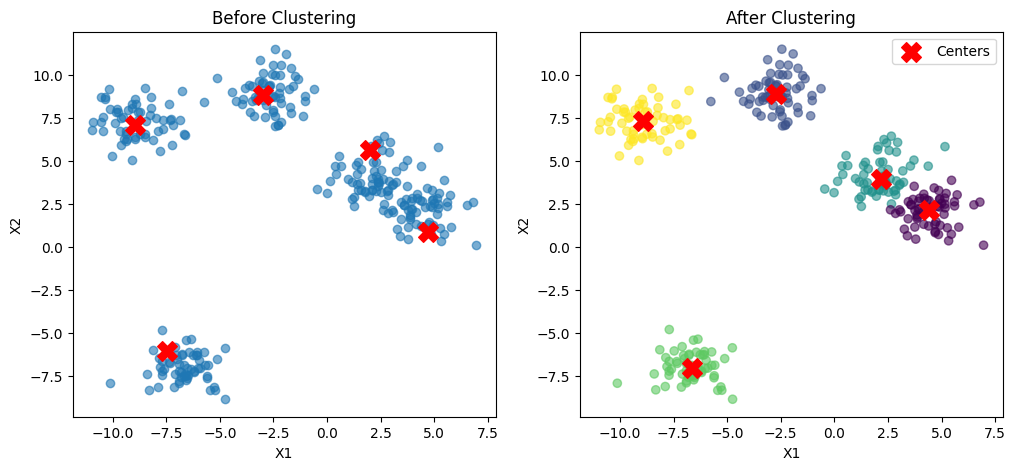

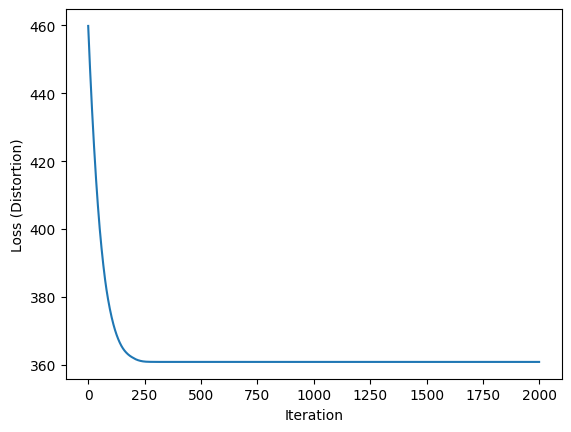

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

class ExemplarClustering:
    def __init__(self, X, K, lr=0.01):
        #super(ExemplarClustering, self).__init__()
        self.K = K
        self.N, self.d = X.shape

        # Initialize cluster centers randomly from X
        self.C = torch.nn.Parameter(X[torch.randperm(self.N)[:K]].clone())
        self.C0 = self.C.clone().detach().numpy()

        # Learning rate
        self.lr = lr

    # Calculating the distortion and cluster assignment
    def forward(self, X): #given a matrix
        # Compute squared Euclidean distances (N x K)
        distances = torch.cdist(X, self.C, p=2) ** 1

        # Find the minimum distance for each point in X to the point in C and the points themselves (cluster assignment)
        min_distances, cluster_assignments = torch.min(distances, dim=1)
        # the above function can be conceptually interpreted as the cluster assignment function above a(x;C).

        # Compute total distortion
        distortion = torch.sum(min_distances)
        return distortion, cluster_assignments

    def fit(self, X, epochs=500):
        optimizer = torch.optim.Adam([self.C], lr=self.lr)
        self.losses = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss, _ = self.forward(X)  # Compute distortion
            loss.backward()         # Compute gradients
            optimizer.step()        # Update cluster centers
            self.losses.append(loss.item()) #save losses for plotting
            # Print loss every few epochs (iterations through the given training set)
            if (epoch) % 10 == 0:
                print(f"Epoch {epoch+1}, Distortion: {loss.item():.4f}")

    def predict(self, X):
        _, cluster_assignments = self.forward(X)
        return cluster_assignments

# Generate synthetic dataset using sklearn's make_blobs
X_np, _ = make_blobs(n_samples=300, centers=5, n_features=2, random_state=42)

# Convert to PyTorch tensor
X = torch.tensor(X_np, dtype=torch.float32)

# Train the model
k = 5
model = ExemplarClustering(X, K = k, lr=0.01)
model.fit(X, epochs=2000)

# Get cluster assignments
cluster_assignments = model.predict(X).numpy()

# Convert cluster centers to numpy
C_np = model.C.detach().numpy()
# Plot "Before Clustering" with true labels
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_np[:, 0], X_np[:, 1], cmap='tab10', alpha=0.6)
plt.scatter(model.C0[:, 0], model.C0[:, 1], color='red', marker='X', s=200, label='Centers')

plt.title("Before Clustering")
plt.xlabel("X1")
plt.ylabel("X2")


# Plot "After Clustering" with predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_np[:, 0], X_np[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.6)
plt.scatter(C_np[:, 0], C_np[:, 1], color='red', marker='X', s=200, label='Centers')
plt.title("After Clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()

# Show the plots
plt.show()
plt.figure();plt.plot(model.losses); plt.xlabel('Iteration'); plt.ylabel('Loss (Distortion)');

# Exercise Question:

1. Try with different K
2. Try for another dataset
3. Try with a different distance function (e.g., L1 distance) to calculate distortion
4. Try with a different loss function
5. Code an additional constraint that certain pair of points must always end up in the same cluster
6. Code an additional constraint that certain pair of points must always end up in different clusters